In [18]:
import glob
import os
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader, random_split
import time
import matplotlib
import matplotlib.pyplot as plt
from utils.sort import natural_sort_key
from DyUNETA import DynamicAttentionUNET

In [4]:
device = torch.device('cuda')

In [6]:
class CSIDataset(Dataset):
    def __init__(self, roots):
        self.files = []
        for root in roots:
            self.files.extend(glob.glob(root))
    def __len__(self):
        return len(self.files)        
            
    def __getitem__(self, index):
        csi_amp_data = np.load(self.files[index])
        keypoints_path= self.files[index].replace(r"preprocess_csi\30_sub", "JHM")
        keypoints = np.load(keypoints_path, allow_pickle=True)
       
        return torch.Tensor(csi_amp_data), torch.Tensor(keypoints)

In [7]:
DataPath = [r'D:\CSKU\NCU\workspace\multi-person-data\preprocess_csi\30_sub\G[1-3]\A[1-3]\*.npy',
            r'D:\CSKU\NCU\workspace\multi-person-data\preprocess_csi\30_sub\G[4-7]\A[1-4]\*.npy',]

In [8]:
dataset = CSIDataset(DataPath)

# setup split size
split_ratio = 0.6
train_size = int(split_ratio*len(dataset))
val_size = int((len(dataset) - train_size + 1) * 0.5)
test_size = int((len(dataset) - train_size + 1) * 0.5)
# print(train_size, val_size, test_size)
# print(train_size + val_size + test_size)

# split train, val, test dataset
train_dataset, val_dataset, test_dataset = random_split(
    dataset, lengths=[train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(0)
)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=True)

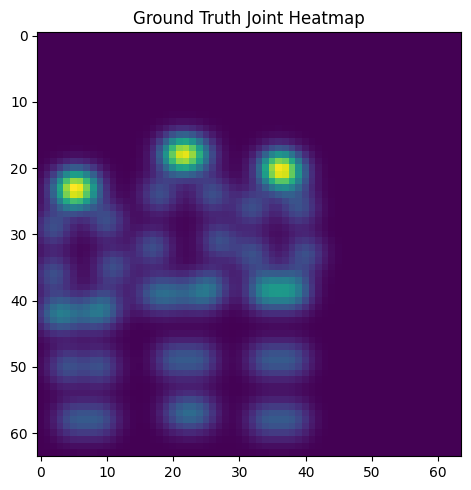

In [6]:
# Get a sample from train dataset
sample_data = next(iter(train_dataloader))
csi_amp, heatmaps = sample_data

# Get the first sample from the batch
ground_truth = heatmaps[0].numpy()

# Create a figure with 2 subplots side by side
plt.figure(figsize=(12, 5))

# Plot ground truth heatmap
plt.imshow(np.sum(ground_truth, axis=0))
plt.title('Ground Truth Joint Heatmap')

plt.tight_layout()
plt.show()

In [56]:
# Hyperparameters
lr = 0.001
epochs = 200
model = DynamicAttentionUNET(1, (4,30,6)).to(device)

criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [41]:
def weighted_mse_loss(input, target, weight):
    # print(input.shape, target.shape)
    return torch.sum(weight * (input - target) ** 2)

# init weight
w = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
print(w.__len__())

17


In [57]:
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}: lr = {optimizer.param_groups[0]['lr']}") # Verbose callout

    model.train() # Set model to training mode
    total_train_loss = 0

    with tqdm(train_dataloader, unit='batch', desc='Train') as t_loader:

        # ---------------------------------------------------------------
        #                           Training 
        # ---------------------------------------------------------------
        for idx, data in enumerate(t_loader):
            try:
                amp = data[0].to(device)
                kp = data[1].to(device) # [batch, 17, 128, 128]
                
                # Forward pass
                output, _ = model(amp)

                # Compute loss
                # Method 1: MSE Loss
                # train_loss = criterion(output, kp)
                
                # # Method 2: Weighted MSE Loss
                train_loss = 0
                for i in range(17): # Loss per keypoint
                    train_loss += weighted_mse_loss(output[:,i,:], kp[:, i, :], w[i])
                train_loss = torch.div(train_loss, 34)

                # Backward pass and optimization
                optimizer.zero_grad()
                train_loss.backward()
                optimizer.step()

                total_train_loss += train_loss.detach().item()
            except ValueError as e:
                print(f"Error in batch {idx}: {e}")
                continue
            avg_train_loss = total_train_loss / (idx + 1)
            t_loader.set_postfix(loss=f'{total_train_loss}', avgloss=f'{avg_train_loss:.6f}')

        train_loss_list.append(avg_train_loss)

        # ---------------------------------------------------------------
        #                           Validation 
        # ---------------------------------------------------------------
        model.eval() # Set model to evaluation mode
        total_val_loss = 0
        
        with tqdm(val_dataloader, unit='batch', desc='Validate') as t_loader:
            for idx, data in enumerate(t_loader):
                amp = data[0].to(device)
                kp = data[1].to(device) 

                # Predict
                output, _ = model(amp)

                # Compute loss
                # Method 1: MSE Loss
                # val_loss = criterion(output, kp)
                
                # # Method 2: Weighted MSE Loss
                val_loss = 0
                for i in range(17): # Loss per keypoint
                    val_loss += weighted_mse_loss(output[:,i,:], kp[:, i, :], w[i])
                val_loss = torch.div(val_loss, 34)

                total_val_loss += val_loss.detach().item()
                avg_val_loss = total_val_loss / (idx + 1)
                t_loader.set_postfix(loss=f'{total_val_loss}', avgloss=f'{avg_val_loss:.6f}')
        val_loss_list.append(avg_val_loss)

Epoch 1: lr = 0.001


Validate: 100%|██████████| 22/22 [00:06<00:00,  3.29batch/s, avgloss=2412.827426, loss=53082.203369140625]


Epoch 2: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.49batch/s, avgloss=1657.153365, loss=36457.3740234375]  


Epoch 3: lr = 0.001


Validate: 100%|██████████| 22/22 [00:06<00:00,  3.41batch/s, avgloss=1476.661937, loss=32486.562622070312]


Epoch 4: lr = 0.001


Validate: 100%|██████████| 22/22 [00:06<00:00,  3.44batch/s, avgloss=1374.996865, loss=30249.931030273438]


Epoch 5: lr = 0.001


Validate: 100%|██████████| 22/22 [00:06<00:00,  3.39batch/s, avgloss=1325.249234, loss=29155.483154296875]


Epoch 6: lr = 0.001


Validate: 100%|██████████| 22/22 [00:06<00:00,  3.43batch/s, avgloss=1302.585727, loss=28656.885986328125]


Epoch 7: lr = 0.001


Validate: 100%|██████████| 22/22 [00:06<00:00,  3.42batch/s, avgloss=1240.975941, loss=27301.470703125]   


Epoch 8: lr = 0.001


Validate: 100%|██████████| 22/22 [00:06<00:00,  3.46batch/s, avgloss=1237.054077, loss=27215.189697265625]


Epoch 9: lr = 0.001


Validate: 100%|██████████| 22/22 [00:06<00:00,  3.29batch/s, avgloss=1201.803667, loss=26439.6806640625]  


Epoch 10: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.09batch/s, avgloss=1185.846075, loss=26088.613647460938]


Epoch 11: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.72batch/s, avgloss=1166.402571, loss=25660.856567382812]


Epoch 12: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.70batch/s, avgloss=1167.328891, loss=25681.235595703125]


Epoch 13: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.79batch/s, avgloss=1146.297202, loss=25218.538452148438]


Epoch 14: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.09batch/s, avgloss=1195.863337, loss=26308.993408203125]


Epoch 15: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.99batch/s, avgloss=1180.691123, loss=25975.204711914062]


Epoch 16: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.99batch/s, avgloss=1163.966447, loss=25607.261840820312]


Epoch 17: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.04batch/s, avgloss=1134.781616, loss=24965.195556640625]


Epoch 18: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.03batch/s, avgloss=1111.180148, loss=24445.963256835938]


Epoch 19: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.11batch/s, avgloss=1101.549316, loss=24234.0849609375]  


Epoch 20: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.94batch/s, avgloss=1092.671825, loss=24038.780151367188]


Epoch 21: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.73batch/s, avgloss=1088.845398, loss=23954.598754882812]


Epoch 22: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.05batch/s, avgloss=1080.400099, loss=23768.802185058594]


Epoch 23: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.52batch/s, avgloss=1082.516080, loss=23815.353759765625]


Epoch 24: lr = 0.001


Validate: 100%|██████████| 22/22 [00:05<00:00,  4.25batch/s, avgloss=1073.913899, loss=23626.10577392578] 


Epoch 25: lr = 0.001


Validate: 100%|██████████| 22/22 [00:05<00:00,  3.72batch/s, avgloss=1065.902277, loss=23449.85009765625] 


Epoch 26: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.51batch/s, avgloss=1070.388475, loss=23548.546447753906]


Epoch 27: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.19batch/s, avgloss=1057.163613, loss=23257.599487304688]


Epoch 28: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.97batch/s, avgloss=1059.330417, loss=23305.269165039062]


Epoch 29: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.10batch/s, avgloss=1072.103577, loss=23586.278686523438]


Epoch 30: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.20batch/s, avgloss=1061.994621, loss=23363.88165283203] 


Epoch 31: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.02batch/s, avgloss=1024.865176, loss=22547.03387451172] 


Epoch 32: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.07batch/s, avgloss=1170.774003, loss=25757.028076171875]


Epoch 33: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.06batch/s, avgloss=1054.513369, loss=23199.29412841797] 


Epoch 34: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.09batch/s, avgloss=1144.252214, loss=25173.548706054688]


Epoch 35: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.04batch/s, avgloss=1038.761852, loss=22852.7607421875]  


Epoch 36: lr = 0.001


Validate: 100%|██████████| 22/22 [00:07<00:00,  3.02batch/s, avgloss=1043.361772, loss=22953.958984375]   


Epoch 37: lr = 0.001


Validate: 100%|██████████| 22/22 [00:06<00:00,  3.18batch/s, avgloss=997.803250, loss=21951.671508789062]


Epoch 38: lr = 0.001


Validate: 100%|██████████| 22/22 [00:06<00:00,  3.44batch/s, avgloss=1019.144490, loss=22421.178771972656]


Epoch 39: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.80batch/s, avgloss=885.236414, loss=19475.201110839844]


Epoch 40: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.12batch/s, avgloss=1071.654125, loss=23576.390747070312]


Epoch 41: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.88batch/s, avgloss=891.138700, loss=19605.051391601562]


Epoch 42: lr = 0.001


Validate: 100%|██████████| 22/22 [00:06<00:00,  3.31batch/s, avgloss=1085.016388, loss=23870.36053466797] 


Epoch 43: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.90batch/s, avgloss=926.327093, loss=20379.196044921875]


Epoch 44: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.22batch/s, avgloss=937.085083, loss=20615.871826171875]


Epoch 45: lr = 0.001


Validate: 100%|██████████| 22/22 [00:05<00:00,  4.05batch/s, avgloss=880.992404, loss=19381.832885742188]


Epoch 46: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.77batch/s, avgloss=851.142106, loss=18725.126342773438]


Epoch 47: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.84batch/s, avgloss=988.994562, loss=21757.88037109375] 


Epoch 48: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.70batch/s, avgloss=911.246615, loss=20047.425537109375]


Epoch 49: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.67batch/s, avgloss=828.649198, loss=18230.282348632812]


Epoch 50: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.71batch/s, avgloss=783.744471, loss=17242.378356933594]


Epoch 51: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.97batch/s, avgloss=867.447862, loss=19083.852966308594]


Epoch 52: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.09batch/s, avgloss=835.095570, loss=18372.1025390625]  


Epoch 53: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.01batch/s, avgloss=813.936537, loss=17906.60382080078] 


Epoch 54: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.02batch/s, avgloss=733.348516, loss=16133.667358398438]


Epoch 55: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.94batch/s, avgloss=736.197415, loss=16196.343139648438]


Epoch 56: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.86batch/s, avgloss=841.337422, loss=18509.423278808594]


Epoch 57: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.10batch/s, avgloss=778.855164, loss=17134.813598632812]


Epoch 58: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.09batch/s, avgloss=774.660794, loss=17042.537475585938]


Epoch 59: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.95batch/s, avgloss=662.822299, loss=14582.090576171875]


Epoch 60: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.69batch/s, avgloss=668.443115, loss=14705.74853515625] 


Epoch 61: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.72batch/s, avgloss=681.484289, loss=14992.654357910156]


Epoch 62: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.67batch/s, avgloss=692.475272, loss=15234.455993652344]


Epoch 63: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.97batch/s, avgloss=681.395330, loss=14990.697265625]   


Epoch 64: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.93batch/s, avgloss=744.655457, loss=16382.420043945312]


Epoch 65: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.18batch/s, avgloss=775.439758, loss=17059.674682617188]


Epoch 66: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.79batch/s, avgloss=663.243822, loss=14591.364074707031]


Epoch 67: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.05batch/s, avgloss=668.855810, loss=14714.827819824219]


Epoch 68: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.15batch/s, avgloss=760.062275, loss=16721.370056152344]


Epoch 69: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.99batch/s, avgloss=709.069794, loss=15599.535461425781]


Epoch 70: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.76batch/s, avgloss=680.529777, loss=14971.655090332031]


Epoch 71: lr = 0.001


Validate: 100%|██████████| 22/22 [00:06<00:00,  3.39batch/s, avgloss=660.331094, loss=14527.284057617188]


Epoch 72: lr = 0.001


Validate: 100%|██████████| 22/22 [00:06<00:00,  3.45batch/s, avgloss=616.364904, loss=13560.027893066406]


Epoch 73: lr = 0.001


Validate: 100%|██████████| 22/22 [00:06<00:00,  3.50batch/s, avgloss=712.820496, loss=15682.050903320312]


Epoch 74: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.67batch/s, avgloss=625.036097, loss=13750.794128417969]


Epoch 75: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.13batch/s, avgloss=739.439262, loss=16267.663757324219]


Epoch 76: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.05batch/s, avgloss=702.320274, loss=15451.046020507812]


Epoch 77: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.00batch/s, avgloss=698.868896, loss=15375.11572265625] 


Epoch 78: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.98batch/s, avgloss=685.841142, loss=15088.505126953125]


Epoch 79: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.95batch/s, avgloss=621.766224, loss=13678.85693359375] 


Epoch 80: lr = 0.001


Validate: 100%|██████████| 22/22 [00:06<00:00,  3.36batch/s, avgloss=649.220062, loss=14282.841369628906]


Epoch 81: lr = 0.001


Validate: 100%|██████████| 22/22 [00:06<00:00,  3.57batch/s, avgloss=626.354592, loss=13779.801025390625]


Epoch 82: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.12batch/s, avgloss=690.010551, loss=15180.232116699219]


Epoch 83: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.13batch/s, avgloss=699.443387, loss=15387.754516601562]


Epoch 84: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.72batch/s, avgloss=603.181760, loss=13269.998718261719]


Epoch 85: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.76batch/s, avgloss=588.291149, loss=12942.4052734375]  


Epoch 86: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.84batch/s, avgloss=773.746313, loss=17022.418884277344]


Epoch 87: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.49batch/s, avgloss=620.387121, loss=13648.516662597656]


Epoch 88: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.93batch/s, avgloss=592.489853, loss=13034.776763916016]


Epoch 89: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.06batch/s, avgloss=570.520006, loss=12551.440124511719]


Epoch 90: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.92batch/s, avgloss=659.961731, loss=14519.158081054688]


Epoch 91: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.03batch/s, avgloss=616.323470, loss=13559.116333007812]


Epoch 92: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.98batch/s, avgloss=594.341170, loss=13075.505737304688]


Epoch 93: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.94batch/s, avgloss=570.942466, loss=12560.734252929688]


Epoch 94: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.98batch/s, avgloss=570.247767, loss=12545.450866699219]


Epoch 95: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.17batch/s, avgloss=563.736579, loss=12402.20474243164] 


Epoch 96: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.12batch/s, avgloss=602.692868, loss=13259.243103027344]


Epoch 97: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.68batch/s, avgloss=556.284938, loss=12238.268646240234]


Epoch 98: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.80batch/s, avgloss=613.322024, loss=13493.084533691406]


Epoch 99: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.59batch/s, avgloss=630.152835, loss=13863.362365722656]


Epoch 100: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.04batch/s, avgloss=572.135738, loss=12586.986236572266]


Epoch 101: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.24batch/s, avgloss=585.985868, loss=12891.689086914062]


Epoch 102: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.01batch/s, avgloss=627.486594, loss=13804.705078125]   


Epoch 103: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.89batch/s, avgloss=680.502014, loss=14971.044311523438]


Epoch 104: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.07batch/s, avgloss=585.306076, loss=12876.733673095703]


Epoch 105: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.99batch/s, avgloss=594.081360, loss=13069.789916992188]


Epoch 106: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.99batch/s, avgloss=580.485429, loss=12770.679443359375]


Epoch 107: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.15batch/s, avgloss=636.079118, loss=13993.740600585938]


Epoch 108: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.05batch/s, avgloss=574.187800, loss=12632.131591796875]


Epoch 109: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.69batch/s, avgloss=577.041676, loss=12694.916870117188]


Epoch 110: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.70batch/s, avgloss=620.258567, loss=13645.6884765625]  


Epoch 111: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.75batch/s, avgloss=580.752286, loss=12776.55029296875] 


Epoch 112: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.63batch/s, avgloss=587.210421, loss=12918.629272460938]


Epoch 113: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.02batch/s, avgloss=568.883173, loss=12515.429809570312]


Epoch 114: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.99batch/s, avgloss=591.965590, loss=13023.242980957031]


Epoch 115: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.95batch/s, avgloss=577.914061, loss=12714.109344482422]


Epoch 116: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.20batch/s, avgloss=567.902962, loss=12493.865173339844]


Epoch 117: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.93batch/s, avgloss=585.845046, loss=12888.591003417969]


Epoch 118: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.92batch/s, avgloss=629.447804, loss=13847.851684570312]


Epoch 119: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.99batch/s, avgloss=569.010047, loss=12518.22103881836] 


Epoch 120: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.12batch/s, avgloss=572.307752, loss=12590.770538330078]


Epoch 121: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.02batch/s, avgloss=582.075534, loss=12805.661743164062]


Epoch 122: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.76batch/s, avgloss=604.031025, loss=13288.682556152344]


Epoch 123: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.70batch/s, avgloss=598.558613, loss=13168.289489746094]


Epoch 124: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.62batch/s, avgloss=604.035140, loss=13288.773071289062]


Epoch 125: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.95batch/s, avgloss=622.490165, loss=13694.783630371094]


Epoch 126: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.83batch/s, avgloss=568.205923, loss=12500.530303955078]


Epoch 127: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.04batch/s, avgloss=559.100626, loss=12300.213775634766]


Epoch 128: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.10batch/s, avgloss=574.294571, loss=12634.480560302734]


Epoch 129: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.96batch/s, avgloss=593.523881, loss=13057.525390625]   


Epoch 130: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.03batch/s, avgloss=594.540427, loss=13079.889404296875]


Epoch 131: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.74batch/s, avgloss=634.296897, loss=13954.53173828125] 


Epoch 132: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.82batch/s, avgloss=589.516647, loss=12969.366241455078]


Epoch 133: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.96batch/s, avgloss=586.478156, loss=12902.519439697266]


Epoch 134: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.69batch/s, avgloss=634.591900, loss=13961.021789550781]


Epoch 135: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.64batch/s, avgloss=585.276174, loss=12876.07583618164] 


Epoch 136: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.68batch/s, avgloss=690.038832, loss=15180.854309082031]


Epoch 137: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.69batch/s, avgloss=581.176439, loss=12785.881652832031]


Epoch 138: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.94batch/s, avgloss=580.091372, loss=12762.010192871094]


Epoch 139: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.92batch/s, avgloss=566.575101, loss=12464.652221679688]


Epoch 140: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.95batch/s, avgloss=574.041964, loss=12628.923217773438]


Epoch 141: lr = 0.001


Validate: 100%|██████████| 22/22 [00:05<00:00,  4.33batch/s, avgloss=608.619440, loss=13389.627685546875]


Epoch 142: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.96batch/s, avgloss=573.083395, loss=12607.834686279297]


Epoch 143: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.07batch/s, avgloss=682.720021, loss=15019.840454101562]


Epoch 144: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.10batch/s, avgloss=669.771093, loss=14734.964050292969]


Epoch 145: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.01batch/s, avgloss=621.580389, loss=13674.7685546875]  


Epoch 146: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.99batch/s, avgloss=660.594394, loss=14533.07666015625] 


Epoch 147: lr = 0.001


Validate: 100%|██████████| 22/22 [00:06<00:00,  3.24batch/s, avgloss=589.492493, loss=12968.834838867188]


Epoch 148: lr = 0.001


Validate: 100%|██████████| 22/22 [00:06<00:00,  3.22batch/s, avgloss=585.379267, loss=12878.343872070312]


Epoch 149: lr = 0.001


Validate: 100%|██████████| 22/22 [00:05<00:00,  3.74batch/s, avgloss=578.697862, loss=12731.352966308594]


Epoch 150: lr = 0.001


Validate: 100%|██████████| 22/22 [00:05<00:00,  3.71batch/s, avgloss=572.868066, loss=12603.097442626953]


Epoch 151: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.04batch/s, avgloss=586.643860, loss=12906.164916992188]


Epoch 152: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.47batch/s, avgloss=565.731714, loss=12446.097717285156]


Epoch 153: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.99batch/s, avgloss=570.783382, loss=12557.234405517578]


Epoch 154: lr = 0.001


Validate: 100%|██████████| 22/22 [00:05<00:00,  3.67batch/s, avgloss=596.336673, loss=13119.406799316406]


Epoch 155: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.44batch/s, avgloss=595.820762, loss=13108.056762695312]


Epoch 156: lr = 0.001


Validate: 100%|██████████| 22/22 [00:06<00:00,  3.46batch/s, avgloss=582.989671, loss=12825.772766113281]


Epoch 157: lr = 0.001


Validate: 100%|██████████| 22/22 [00:06<00:00,  3.42batch/s, avgloss=570.372366, loss=12548.19204711914] 


Epoch 158: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.60batch/s, avgloss=640.286127, loss=14086.294799804688]


Epoch 159: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.67batch/s, avgloss=623.915667, loss=13726.14468383789] 


Epoch 160: lr = 0.001


Validate: 100%|██████████| 22/22 [00:05<00:00,  4.35batch/s, avgloss=607.427503, loss=13363.405059814453]


Epoch 161: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.67batch/s, avgloss=760.573098, loss=16732.608154296875]


Epoch 162: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.96batch/s, avgloss=606.313033, loss=13338.88671875]    


Epoch 163: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.99batch/s, avgloss=658.231229, loss=14481.087036132812]


Epoch 164: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.02batch/s, avgloss=624.927868, loss=13748.4130859375]  


Epoch 165: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.97batch/s, avgloss=590.124118, loss=12982.730590820312]


Epoch 166: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.97batch/s, avgloss=571.496578, loss=12572.924713134766]


Epoch 167: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.00batch/s, avgloss=589.220620, loss=12962.853637695312]


Epoch 168: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.05batch/s, avgloss=569.219033, loss=12522.818725585938]


Epoch 169: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.99batch/s, avgloss=573.554710, loss=12618.20361328125] 


Epoch 170: lr = 0.001


Validate: 100%|██████████| 22/22 [00:06<00:00,  3.63batch/s, avgloss=580.607824, loss=12773.372131347656]


Epoch 171: lr = 0.001


Validate: 100%|██████████| 22/22 [00:06<00:00,  3.35batch/s, avgloss=579.363724, loss=12746.001922607422]


Epoch 172: lr = 0.001


Validate: 100%|██████████| 22/22 [00:06<00:00,  3.32batch/s, avgloss=575.823453, loss=12668.115966796875]


Epoch 173: lr = 0.001


Validate: 100%|██████████| 22/22 [00:06<00:00,  3.57batch/s, avgloss=585.725933, loss=12885.970520019531]


Epoch 174: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.97batch/s, avgloss=597.487202, loss=13144.718444824219]


Epoch 175: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.72batch/s, avgloss=605.453630, loss=13319.979858398438]


Epoch 176: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.03batch/s, avgloss=631.881750, loss=13901.398498535156]


Epoch 177: lr = 0.001


Validate: 100%|██████████| 22/22 [00:06<00:00,  3.30batch/s, avgloss=636.280176, loss=13998.163879394531]


Epoch 178: lr = 0.001


Validate: 100%|██████████| 22/22 [00:05<00:00,  3.92batch/s, avgloss=645.995231, loss=14211.895080566406]


Epoch 179: lr = 0.001


Validate: 100%|██████████| 22/22 [00:05<00:00,  3.76batch/s, avgloss=635.069946, loss=13971.538818359375]


Epoch 180: lr = 0.001


Validate: 100%|██████████| 22/22 [00:06<00:00,  3.40batch/s, avgloss=610.427840, loss=13429.412475585938]


Epoch 181: lr = 0.001


Validate: 100%|██████████| 22/22 [00:06<00:00,  3.45batch/s, avgloss=584.135255, loss=12850.975616455078]


Epoch 182: lr = 0.001


Validate: 100%|██████████| 22/22 [00:06<00:00,  3.19batch/s, avgloss=595.309842, loss=13096.816528320312]


Epoch 183: lr = 0.001


Validate: 100%|██████████| 22/22 [00:07<00:00,  3.13batch/s, avgloss=573.161485, loss=12609.552673339844]


Epoch 184: lr = 0.001


Validate: 100%|██████████| 22/22 [00:06<00:00,  3.34batch/s, avgloss=574.080245, loss=12629.765380859375]


Epoch 185: lr = 0.001


Validate: 100%|██████████| 22/22 [00:06<00:00,  3.39batch/s, avgloss=589.640170, loss=12972.083740234375]


Epoch 186: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.79batch/s, avgloss=579.041336, loss=12738.909393310547]


Epoch 187: lr = 0.001


Validate: 100%|██████████| 22/22 [00:06<00:00,  3.28batch/s, avgloss=589.738753, loss=12974.252563476562]


Epoch 188: lr = 0.001


Validate: 100%|██████████| 22/22 [00:06<00:00,  3.39batch/s, avgloss=571.768564, loss=12578.908416748047]


Epoch 189: lr = 0.001


Validate: 100%|██████████| 22/22 [00:06<00:00,  3.37batch/s, avgloss=574.516000, loss=12639.351989746094]


Epoch 190: lr = 0.001


Validate: 100%|██████████| 22/22 [00:06<00:00,  3.37batch/s, avgloss=566.944882, loss=12472.787414550781]


Epoch 191: lr = 0.001


Validate: 100%|██████████| 22/22 [00:06<00:00,  3.32batch/s, avgloss=572.004801, loss=12584.10562133789] 


Epoch 192: lr = 0.001


Validate: 100%|██████████| 22/22 [00:06<00:00,  3.32batch/s, avgloss=579.830515, loss=12756.27133178711] 


Epoch 193: lr = 0.001


Validate: 100%|██████████| 22/22 [00:05<00:00,  4.25batch/s, avgloss=585.469131, loss=12880.320892333984]


Epoch 194: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.66batch/s, avgloss=585.273099, loss=12876.008178710938]


Epoch 195: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.88batch/s, avgloss=577.404738, loss=12702.904235839844]


Epoch 196: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.96batch/s, avgloss=580.642996, loss=12774.145904541016]


Epoch 197: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.05batch/s, avgloss=580.805258, loss=12777.71566772461] 


Epoch 198: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  4.87batch/s, avgloss=574.956863, loss=12649.050994873047]


Epoch 199: lr = 0.001


Validate: 100%|██████████| 22/22 [00:04<00:00,  5.00batch/s, avgloss=591.800247, loss=13019.605438232422]


Epoch 200: lr = 0.001


Validate: 100%|██████████| 22/22 [00:05<00:00,  4.04batch/s, avgloss=581.181173, loss=12785.985809326172]


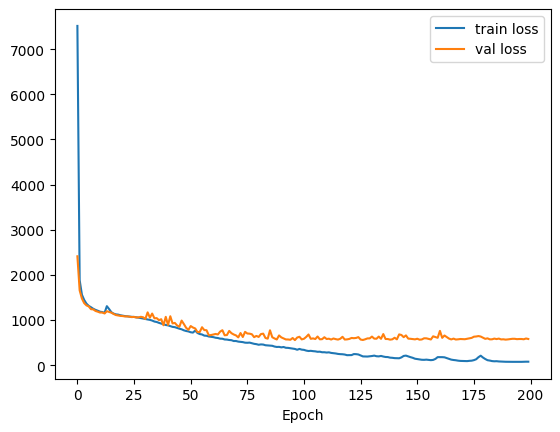

In [58]:
plt.plot(train_loss_list, label='train loss')
plt.plot(val_loss_list, label='val loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
plt.cla()
plt.close("all")

In [ ]:
# torch.save(model.state_dict(), 'dyuneta_200epoch.pth')

# Inference

In [ ]:
# Load model
model = torch.load('dyuneta_200epoch.pth')
model = model.to(device)  # Ensure it is moved to the correct device

# Get a sample from test dataset
sample_data = next(iter(test_dataloader))

(1, 17, 64, 64)


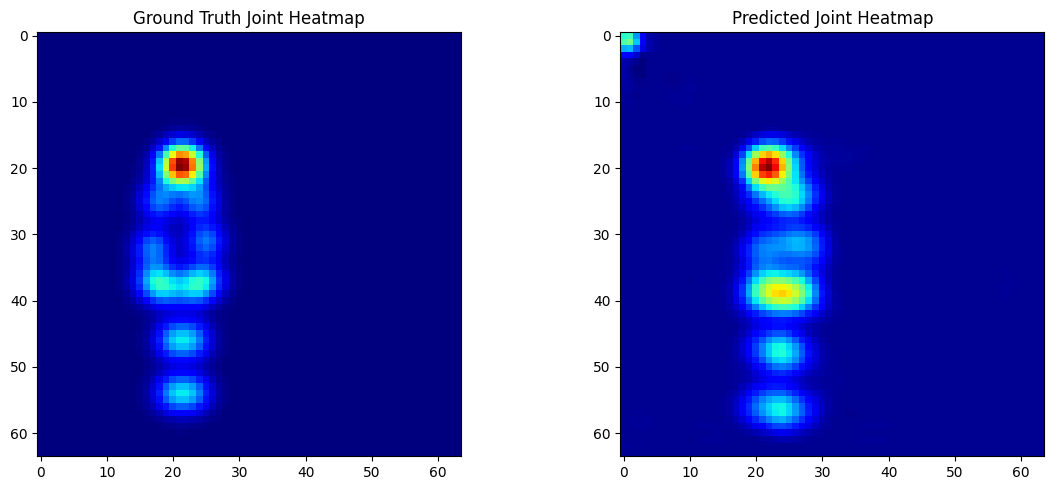

In [8]:
CSIamp_data, heatmaps = sample_data

# Get the first sample from the batch
ground_truth = heatmaps[0].numpy()

# Create a figure with 2 subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot ground truth heatmap
axs[0].imshow(np.sum(ground_truth, axis=0), cmap='jet')
axs[0].set_title('Ground Truth Joint Heatmap')

# Predict
output, _ = model(CSIamp_data.to(device))
output = output.detach().cpu().numpy()
print(output.shape)

# Plot predicted heatmap
axs[1].imshow(np.sum(output[0], axis=0), cmap='jet')
axs[1].set_title('Predicted Joint Heatmap')

plt.tight_layout()
plt.show()


ground truth data shape: (17, 64, 64)
predicted data shape: (1, 17, 64, 64)


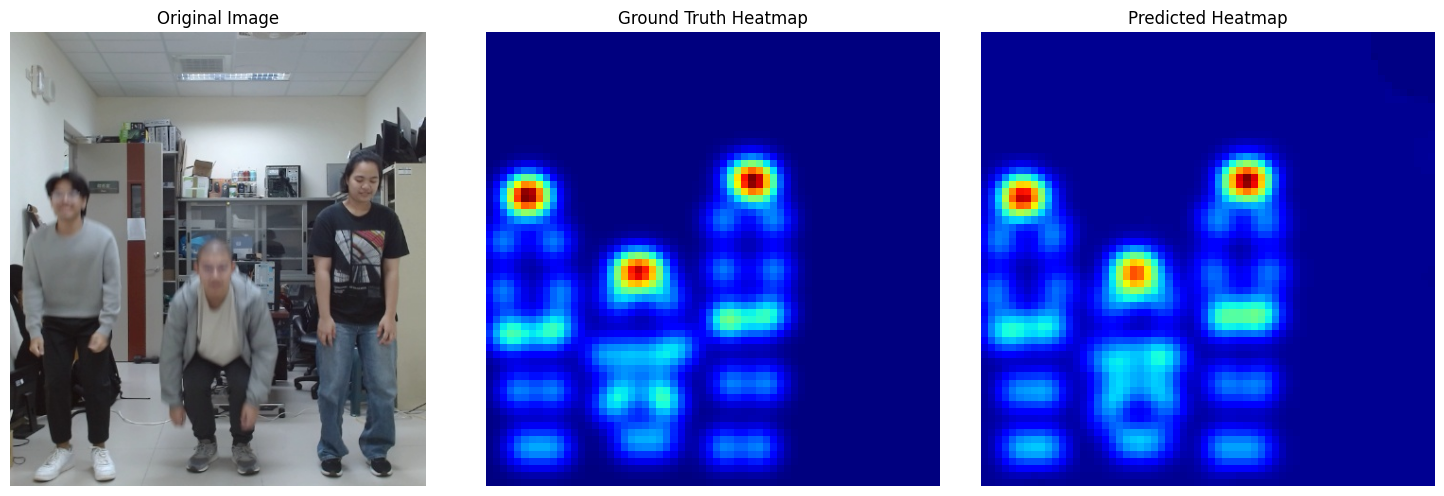

In [9]:
# ground truth
import random
rand_num = random.randint(0, 564)
test_path = f'../multi-person-data/JHM/G7/A2/frame{rand_num}.npy'
gt_data = np.load(test_path)
gt_image = plt.imread(test_path.replace('JHM', 'photo_rename').replace('npy', 'jpg'))
print('ground truth data shape:', gt_data.shape)

# Predict
test_data = torch.from_numpy(np.load(test_path.replace('JHM', 'preprocess_csi/30_sub'))).unsqueeze(0).float()
test_output, _ = model(test_data.to(device))
test_output = test_output.detach().cpu().numpy()
print('predicted data shape:',test_output.shape)

# Create figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot original image
axs[0].imshow(gt_image)
axs[0].set_title('Original Image')
axs[0].axis('off')

# Plot ground truth heatmap
axs[1].imshow(np.sum(gt_data, axis=0), cmap='jet')
axs[1].set_title('Ground Truth Heatmap')
axs[1].axis('off')

# Plot predicted heatmap
axs[2].imshow(np.sum(test_output[0], axis=0), cmap='jet')
axs[2].set_title('Predicted Heatmap')
axs[2].axis('off')

plt.tight_layout()
plt.show()

Euclidean distance: [  0.           0.          10.           0.           0.
 300.37476592   0.           0.         310.85205484  10.
 310.36269106 300.08165555 300.08165555 300.10664771 290.11032384
 150.21318185 150.21318185]
Mean distance: 143.0821269510557


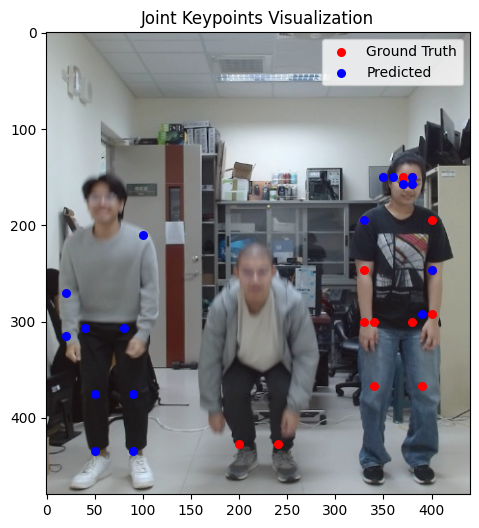

In [10]:
# Convert joint heatmap back into keypoint coordinates
def heatmap2keypoint(heatmap, img_size):
    keypoints = []
    for i in range(17):
        y, x = np.unravel_index(np.argmax(heatmap[i]), heatmap[i].shape)
        # Denormalize coordinates to match original image size
        x = int(x * img_size[0] / heatmap[i].shape[1])
        y = int(y * img_size[1] / heatmap[i].shape[0])
        keypoints.append([x, y])
    return np.array(keypoints)

# Convert joint heatmap back into keypoint coordinates
gt_keypoints = heatmap2keypoint(gt_data, (640, 480))
test_keypoints = heatmap2keypoint(test_output[0], (640, 480))

# Calculate Euclidean distance between ground truth and predicted keypoints
dist = np.linalg.norm(gt_keypoints - test_keypoints, axis=1)
print('Euclidean distance:', dist)
print('Mean distance:', np.mean(dist))

# Visualize the keypoints
plt.figure(figsize=(12, 6))
plt.imshow(gt_image)
plt.scatter(gt_keypoints[:, 0], gt_keypoints[:, 1], c='r', s=30, label='Ground Truth')
plt.scatter(test_keypoints[:, 0], test_keypoints[:, 1], c='b', s=30, label='Predicted')
plt.legend()
plt.title('Joint Keypoints Visualization')
plt.show()